# COSE474-2024F : Deep Learning HW 2

## 0.1 Installation

In [2]:
pip install d2l==1.0.3

##7.1 From Fully Connected Layers to Convolutions

###7.1.1 Invariance

The network's early layers should maintain translation invariance, responding the same way to a patch regardless of its position in the image. These layers focus on local regions (locality principle) without considering distant areas. As the network deepens, layers capture more global and complex features, similar to higher-level vision processes in nature.

### 7.1.2 Constraining the MLP

To start, we consider a multi-layer perceptron (MLP) using two-dimensional images as inputs, with their hidden representations also structured as matrices, maintaining the same shape. Both the input and hidden layers thus retain spatial structure. Let $x_{ij}$ and $h_{ij}$ represent the pixel values at position $(i,j)$ in the input and hidden layers, respectively. To ensure every hidden unit receives input from each pixel, the network uses fourth-order weight tensors $W$ instead of traditional weight matrices. If $b$ represents biases, the fully connected layer can be expressed formally using these tensors.The change from using weight matrices to fourth-order tensors is mainly a reorganization, maintaining a one-to-one correspondence between elements by re-indexing. For each location in the hidden representation, its value is calculated by summing over input pixels weighted by $W$, centered around that location. However, mapping a 1-megapixel image to a hidden layer using this approach requires an enormous number of parameters, far exceeding current computational capabilities.

#### 7.1.2.1 Translation Invariance

To apply the principle of translation invariance, a shift in the input should result in an equivalent shift in the hidden representation. This requires that the weight tensor $W$ and the bias $b$ are not dependent on specific locations $(i,j)$. Instead $W$ becomes a constant kernel $K$ and $b$ is a constant value.This leads to a simplified definition for the hidden representation, which turns out to be a convolution. In essence, pixels around a location $(i,j)$ are weighted by coefficients in $K$ to determine the value at that location. This method uses far fewer parameters than before since $K$ does not depend on the position in the image. The total number of parameters is now proportional to $k$, the size of the local neighborhood, rather than the entire image size. This approach is an advancement and is seen in early models like time-delay neural networks (TDNNs).

#### 7.1.2.2 Locality

Invoking the principle of locality, we assume that information relevant to a given location $(i,j)$ can be found within a limited range $k$. Outside this range, weights in the convolution kernel $K$ are set to zero, reducing the number of parameters from being dependent on the entire image size to only being proportional to the local neighborhood, $k$, which is much smaller.
This transformation defines the convolutional layer. Convolutional Neural Networks (CNNs) use these layers, where $K$, also called the convolution kernel or filter, represents the learnable parameters. This approach drastically reduces the number of parameters needed—from billions to just a few hundred per layer—while maintaining the input and hidden representation dimensions.

The trade-off for this parameter reduction is that features become translation invariant and only local information is used for hidden activations. This inductive bias, when aligned with reality (e.g., images being translation invariant), leads to efficient and generalizable models. However, if the bias doesn’t match reality, the model may struggle.

To capture larger and more complex features, deeper layers are built by repeatedly stacking convolutional layers with nonlinearities.

### 7.1.3 Convolutions

$$\mathbf{H}_{i,j} = u + \sum_{a=-\Delta}^{\Delta} \sum_{b=-\Delta}^{\Delta} \mathbf{V}_{a,b} \mathbf{X}_{i+a,j+b}.$$

the mathematical definition of convolution involves measuring the overlap between two functions when one is flipped and shifted. For discrete objects, the integral becomes a sum. In the case of two-dimensional tensors, the convolution formula sums over two indices. Although this formula resembles the previous definition (7.1.3), the main difference is using index differences rather than sums, a largely notational change. The earlier definition (7.1.3) technically describes a cross-correlation rather than a convolution, which will be clarified further.

### 7.1.4 Channels

$$\mathbf{H}_{i,j,d} = \sum_{a=-\Delta}^{\Delta} \sum_{b=-\Delta}^{\Delta} \sum_{c} \mathbf{V}_{a,b,c,d} \mathbf{X}_{i+a,j+b,c}.
$$

The approach needs to account for the fact that images have three color channels: red, green, and blue, making them third-order tensors (height, width, and channels). As a result, the convolutional filter must also be adapted to handle these channels, turning from a two-dimensional filter into one that operates across the third dimension.

Hidden representations are similarly treated as third-order tensors, with multiple feature maps (or channels) at each spatial location. These feature maps capture different aspects of the image, such as edges or textures, especially in the lower layers. To support multiple channels in inputs and hidden layers, a fourth coordinate is added to the weight tensor.

This generalized approach (equation 7.1.7) defines the convolutional layer for multi-channel inputs, where the filter spans all input channels and outputs multiple feature maps. Further, the chapter will address how to efficiently combine hidden representations, stack layers, choose activation functions, and design effective networks for tasks such as detecting objects like "Waldo" in images.

##7.2 Convolutions for Images

In [3]:
import torch
from torch import nn
from d2l import torch as d2l

### 7.2.1 The Cross-Correlation Operation

In [4]:
def corr2d(X, K):
    """Compute 2D cross-correlation."""
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()
    return Y

In [5]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

###7.2.2 Convolutional Layers

In [6]:
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

### 7.2.3 Object Edge Detection in Images

In [7]:
X = torch.ones((6, 8))
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

In [8]:
K = torch.tensor([[1.0, -1.0]])

In [9]:
Y = corr2d(X, K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

In [10]:
corr2d(X.t(), K)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

### 7.2.4 Learning a Kernel

In [11]:
# Construct a two-dimensional convolutional layer with 1 output channel and a
# kernel of shape (1, 2). For the sake of simplicity, we ignore the bias here
conv2d = nn.LazyConv2d(1, kernel_size=(1, 2), bias=False)

# The two-dimensional convolutional layer uses four-dimensional input and
# output in the format of (example, channel, height, width), where the batch
# size (number of examples in the batch) and the number of channels are both 1
X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))
lr = 3e-2  # Learning rate

for i in range(10):
    Y_hat = conv2d(X)
    l = (Y_hat - Y) ** 2
    conv2d.zero_grad()
    l.sum().backward()
    # Update the kernel
    conv2d.weight.data[:] -= lr * conv2d.weight.grad
    if (i + 1) % 2 == 0:
        print(f'epoch {i + 1}, loss {l.sum():.3f}')

epoch 2, loss 10.568
epoch 4, loss 1.975
epoch 6, loss 0.414
epoch 8, loss 0.103
epoch 10, loss 0.031


In [12]:
conv2d.weight.data.reshape((1, 2))

tensor([[ 0.9679, -0.9996]])

### 7.2.5 Cross-Correlation and Convolution

In deep learning, convolutional layers typically perform cross-correlation rather than strict convolution. If strict convolution is desired, the kernel can be flipped horizontally and vertically before applying the operation. However, because kernels are learned from data, the outputs remain unaffected whether the layer uses cross-correlation or strict convolution.

For example, if a layer performs cross-correlation and learns a kernel, flipping that kernel horizontally and vertically allows it to perform strict convolution while producing the same output. Thus, in practice, there is no difference in the output regardless of the operation used.

Despite the slight difference between cross-correlation and convolution, deep learning literature typically refers to both as "convolution" for simplicity. Additionally, the term "element" is used to describe an entry within any tensor, such as those representing layer outputs or convolution kernels.

### 7.2.6 Feature Map and Receptive Field

In CNNs, the output of a convolutional layer is often referred to as a feature map, representing learned spatial features (width and height) for the next layer. The receptive field of an element in a layer is the region of the input (including previous layers) that influences the computation of that element during forward propagation. This receptive field can be larger than the input's actual size, especially in deeper networks.

For example, using a $2$ x $2$ convolution kernel, the receptive field for a specific output element consists of four corresponding elements in the input. In a deeper network with another $2$ x $2$ convolutional layer, the receptive field of an output element extends to all four elements of the feature map from the previous layer and encompasses nine elements of the original input.

Receptive fields are named after a concept from neurophysiology, where studies by Hubel and Wiesel in the 1950s and 1960s showed that the visual cortex responds to specific stimuli, such as edges. Field (1987) further demonstrated that similar receptive fields, resembling convolutional kernels, are effective when applied to natural images, drawing parallels between biological and artificial visual systems.

## 7.3 Padding and Stride

In [13]:
import torch
from torch import nn

### 7.3.1 Padding

In [14]:
# We define a helper function to calculate convolutions. It initializes the
# convolutional layer weights and performs corresponding dimensionality
# elevations and reductions on the input and output
def comp_conv2d(conv2d, X):
    # (1, 1) indicates that batch size and the number of channels are both 1
    X = X.reshape((1, 1) + X.shape)
    Y = conv2d(X)
    # Strip the first two dimensions: examples and channels
    return Y.reshape(Y.shape[2:])

# 1 row and column is padded on either side, so a total of 2 rows or columns
# are added
conv2d = nn.LazyConv2d(1, kernel_size=3, padding=1)
X = torch.rand(size=(8, 8))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

In [15]:
# We use a convolution kernel with height 5 and width 3. The padding on either
# side of the height and width are 2 and 1, respectively
conv2d = nn.LazyConv2d(1, kernel_size=(5, 3), padding=(2, 1))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

### 7.3.2 Stride

In [16]:
conv2d = nn.LazyConv2d(1, kernel_size=3, padding=1, stride=2)
comp_conv2d(conv2d, X).shape

torch.Size([4, 4])

In [17]:
conv2d = nn.LazyConv2d(1, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))
comp_conv2d(conv2d, X).shape

torch.Size([2, 2])

## 7.4 Multiple Input and Multiple Output Channels

In [18]:
import torch
from d2l import torch as d2l

### 7.4.1 Multiple Input Channels

In [19]:
def corr2d_multi_in(X, K):
    # Iterate through the 0th dimension (channel) of K first, then add them up
    return sum(d2l.corr2d(x, k) for x, k in zip(X, K))

In [20]:
X = torch.tensor([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
               [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])
K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])

corr2d_multi_in(X, K)

tensor([[ 56.,  72.],
        [104., 120.]])

### 7.4.2 Multiple Output Channels

In [21]:
def corr2d_multi_in_out(X, K):
    # Iterate through the 0th dimension of K, and each time, perform
    # cross-correlation operations with input X. All of the results are
    # stacked together
    return torch.stack([corr2d_multi_in(X, k) for k in K], 0)

In [22]:
K = torch.stack((K, K + 1, K + 2), 0)
K.shape

torch.Size([3, 2, 2, 2])

In [23]:
corr2d_multi_in_out(X, K)

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

### 7.4.3 $1$ x $1$ Convolutional Layer

In [24]:
def corr2d_multi_in_out_1x1(X, K):
    c_i, h, w = X.shape
    c_o = K.shape[0]
    X = X.reshape((c_i, h * w))
    K = K.reshape((c_o, c_i))
    # Matrix multiplication in the fully connected layer
    Y = torch.matmul(K, X)
    return Y.reshape((c_o, h, w))

In [25]:
X = torch.normal(0, 1, (3, 3, 3))
K = torch.normal(0, 1, (2, 3, 1, 1))
Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)
assert float(torch.abs(Y1 - Y2).sum()) < 1e-6

## 7.5 Pooling

### 7.5.1 Maximum Pooling and Average Pooling

In [26]:
def pool2d(X, pool_size, mode='max'):
    p_h, p_w = pool_size
    Y = torch.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i, j] = X[i: i + p_h, j: j + p_w].max()
            elif mode == 'avg':
                Y[i, j] = X[i: i + p_h, j: j + p_w].mean()
    return Y

In [27]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
pool2d(X, (2, 2))

tensor([[4., 5.],
        [7., 8.]])

In [28]:
pool2d(X, (2, 2), 'avg')

tensor([[2., 3.],
        [5., 6.]])

### 7.5.2 Padding and Stride

In [29]:
X = torch.arange(16, dtype=torch.float32).reshape((1, 1, 4, 4))
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

In [30]:
pool2d = nn.MaxPool2d(3)
# Pooling has no model parameters, hence it needs no initialization
pool2d(X)

tensor([[[[10.]]]])

In [31]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

In [32]:
pool2d = nn.MaxPool2d((2, 3), stride=(2, 3), padding=(0, 1))
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

### 7.5.3 Multiple Channels

In [33]:
X = torch.cat((X, X + 1), 1)
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])

In [34]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[ 6.,  8.],
          [14., 16.]]]])

## 7.6 Convolutional Neural Networks (LeNet)

### 7.6.1 LeNet

In [35]:
def init_cnn(module):
    """Initialize weights for CNNs."""
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)

class LeNet(d2l.Classifier):
    """The LeNet-5 model."""
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.Sigmoid(),
            nn.LazyLinear(84), nn.Sigmoid(),
            nn.LazyLinear(num_classes))

In [36]:
@d2l.add_to_class(d2l.Classifier)
def layer_summary(self, X_shape):
    X = torch.randn(*X_shape)
    for layer in self.net:
        X = layer(X)
        print(layer.__class__.__name__, 'output shape:\t', X.shape)

model = LeNet()
model.layer_summary((1, 1, 28, 28))

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
Sigmoid output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
Sigmoid output shape:	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


### 7.6.2 Training

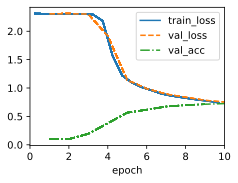

In [37]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = LeNet(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)

## 8.2 Networks Using Blocks (VGG)

In [38]:
import torch
from torch import nn
from d2l import torch as d2l

### 8.2.1 VGG Blocks

In [39]:
def vgg_block(num_convs, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.LazyConv2d(out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

### 8.2.2 VGG Network

In [40]:
class VGG(d2l.Classifier):
    def __init__(self, arch, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        conv_blks = []
        for (num_convs, out_channels) in arch:
            conv_blks.append(vgg_block(num_convs, out_channels))
        self.net = nn.Sequential(
            *conv_blks, nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(num_classes))
        self.net.apply(d2l.init_cnn)

In [41]:
VGG(arch=((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))).layer_summary(
    (1, 1, 224, 224))

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


### 8.2.3 Training

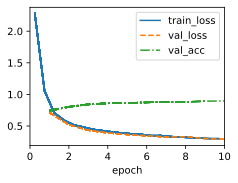

In [42]:
model = VGG(arch=((1, 16), (1, 32), (2, 64), (2, 128), (2, 128)), lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

## 8.6 Residual Networks (ResNet) and ResNetXt

In [44]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

### 8.6.1 Function Classes

The text discusses the concept of function classes $(F)$ in neural networks, representing the set of functions that a network architecture can achieve given its parameters and hyperparameters. The objective is to approximate a "truth" function $(f * f)$ using a function $(f)$ within $F$. Ideally, $(f * f)$ belongs to $F$, but if not, the aim is to find the best approximation of it.

Function classes can be nested or non-nested. In non-nested classes, expanding the class (making it larger) doesn't guarantee getting closer to $(f * f)$. However, in nested function classes, expanding the class will increase the expressive power of the network and improve its accuracy.

The concept of residual networks (ResNet) by He et al. (2016) addresses this. They proposed that additional layers in a deep network should be able to represent the identity function, ensuring that adding layers does not degrade performance. This is achieved through residual blocks, which make it easier to train very deep models. ResNet's success in the 2015 ImageNet competition demonstrated its effectiveness and influenced other areas, including recurrent networks, Transformers, and graph neural networks. ResNets build on earlier work like highway networks but provide a simpler and more effective approach to incorporating identity functions.

### 8.6.2 Residual Blocks

In [45]:
class Residual(nn.Module):
    """The Residual block of ResNet models."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1,
                                   stride=strides)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [46]:
blk = Residual(3)
X = torch.randn(4, 3, 6, 6)
blk(X).shape

torch.Size([4, 3, 6, 6])

In [47]:
blk = Residual(6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

### 8.6.3 ResNet Model

In [48]:
class ResNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [49]:
@d2l.add_to_class(ResNet)
def block(self, num_residuals, num_channels, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(num_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels))
    return nn.Sequential(*blk)

In [50]:
@d2l.add_to_class(ResNet)
def __init__(self, arch, lr=0.1, num_classes=10):
    super(ResNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1())
    for i, b in enumerate(arch):
        self.net.add_module(f'b{i+2}', self.block(*b, first_block=(i==0)))
    self.net.add_module('last', nn.Sequential(
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(num_classes)))
    self.net.apply(d2l.init_cnn)

In [51]:
class ResNet18(ResNet):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__(((2, 64), (2, 128), (2, 256), (2, 512)),
                       lr, num_classes)

ResNet18().layer_summary((1, 1, 96, 96))

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 128, 12, 12])
Sequential output shape:	 torch.Size([1, 256, 6, 6])
Sequential output shape:	 torch.Size([1, 512, 3, 3])
Sequential output shape:	 torch.Size([1, 10])


### 8.6.4 Training

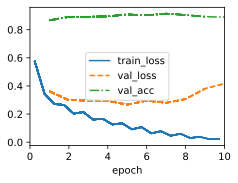

In [52]:
model = ResNet18(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

# Discussions

### Fully Connected Layers to Convolutions Through Constraining the MLP (Discussions)

Fully connected layers treat each input element (such as a pixel in an image) independently, connecting every neuron in one layer to all neurons in the next layer. This approach, while powerful for generic data processing, is inefficient for image data due to two main reasons:

- High Parameter Count: With large inputs like high-resolution images, the number of parameters in fully connected layers becomes enormous, making the network computationally expensive and prone to overfitting.
- Loss of Spatial Structure: Fully connected layers flatten the image into a one-dimensional vector, losing the spatial relationships between neighboring pixels that are critical for recognizing patterns like edges or textures.

### Constraining the MLP (Discussions)

To address these limitations, we constrain the MLP by imposing two key principles: locality and translation invariance.

- Locality Constraint: Instead of allowing neurons to connect to all pixels in the image, we limit each neuron to connect only to a local region of the input. This mimics the natural structure of images, where important information is often found in local patches. By focusing on local interactions, the network can effectively detect basic patterns without considering the entire image at once, significantly reducing the number of parameters.

- Translation Invariance: To further optimize the network, we design it to respond similarly to the same feature (e.g., an edge) regardless of its location in the image. This means that the weights (or kernels) applied to each local patch are shared across the entire image. By shifting the kernel over the image and applying the same weights, the network maintains consistency, capturing patterns wherever they appear. This constraint not only reduces parameters but also enhances the network's ability to generalize across different parts of the image.

### Residual Networks (ResNet) and ResNetXT (Discussions)

- The transition from fully connected layers to convolutional layers in neural networks involved reducing complexity and adapting to the spatial nature of image data. Convolutional layers use local connections and shared weights (kernels) to detect patterns like edges while maintaining spatial relationships, significantly reducing the number of parameters compared to fully connected layers. CNNs handle multi-channel images by extending these kernels across all channels, producing feature maps that capture various aspects of the image. As the network deepens, it builds larger and more complex receptive fields, allowing for the detection of higher-level features and patterns. Residual Networks (ResNet) further optimize this by introducing residual blocks that ensure additional layers don’t degrade performance, enabling much deeper models to be trained effectively, with these principles influencing various modern architectures like RNNs, Transformers, and GNNs.